**Import statements**


In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import constants
import functions

%matplotlib inline

**Load Data**

In [2]:
all_static_data = functions.load_static_sensors()
all_static_data = functions.transform_to_grid_coordinates(all_static_data)
mobile_sensor_data = functions.load_mobile_sensors()
mobile_sensor_data = functions.transform_to_grid_coordinates(mobile_sensor_data)

**Compute predictions for stationary sensors**

In [3]:
mae = []
mse = []
squares = []
pred=[]

start_time = '2018-07-03 00:00:00'
start_window = '2018-07-06 12:00:00'
end_window = '2018-07-06 12:15:00'
offset_timeint = 1

# Fiz isto 6 +1 agora 20
number_of_windows = 30
window = 15
par_grid = functions.create_par()
timeint_on_first_window = 0

for i in range(1, number_of_windows+1):
    end_time = start_window
    # treinar sem dados moveis
    # testar em dados fixos em vez de móveis
    timeint, par_grid = functions.train(all_static_data, None, start_time, end_time, par_grid, window, timeint_on_first_window)
    # prever para t em vez de t+1
    to_test = functions.test_mobile(par_grid, timeint, all_static_data, start_window, end_window, 1)
    # if (i != 1):
    squares.append(to_test.shape[0])
    mae.append(mean_absolute_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    mse.append(mean_squared_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    pred.append(to_test['pred_PM2.5'].values[0])

    start_time = end_time
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    timeint_on_first_window = timeint+1
    

In [4]:
mae

[0.2732553635308218,
 0.10017092420597462,
 0.011323836139349397,
 0.13218113889427607,
 0.001615308354510181,
 0.09509824599228844,
 0.024716933904420535,
 0.878001539089114,
 0.49985161089274777,
 1.2306278816654928,
 0.24671349529921216,
 0.10359111874167393,
 0.021949967164145212,
 0.04320173972937125,
 0.10523734559655462,
 0.1325570489738867,
 0.10737235065381356,
 0.09036776405606928,
 0.12800300543670012,
 0.028083100020834362,
 0.06301319672780314,
 0.020481710054225943,
 0.023872872614411622,
 0.05236017233604923,
 0.01481449614535335,
 0.09272955363300894,
 0.1546490190309619,
 0.029037312235987822,
 0.03594492368665586,
 0.03451081543065726]

In [5]:
mae_no_online = []
mse_no_online = []
squares_no_online = []
pred_no_online=[]
values_read=[]


window = 15
start_window = '2018-07-06 12:00:00'
end_window = '2018-07-06 12:15:00'
offset_timeint = 1
# windows 6
number_of_windows = 30
par_grid = functions.create_par()
start_time = '2018-07-03 00:00:00'
end_time = start_window
timeint, par_grid = functions.train(all_static_data, None, start_time, end_time, par_grid, window)


for i in range(1, number_of_windows+1):
    to_test = functions.test_mobile(par_grid, timeint, all_static_data, start_window, end_window, i)
    squares_no_online.append(to_test.shape[0])
    mae_no_online.append(mean_absolute_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    mse_no_online.append(mean_squared_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    pred_no_online.append(to_test['pred_PM2.5'].values[0])
    values_read.append(to_test['PM2.5'].values[0])
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")

In [6]:
mae_no_online

[0.2732553635308218,
 0.27394346334540864,
 0.18578344914616207,
 0.042794622268915505,
 0.14160025242916896,
 0.2387350253190892,
 0.16877493177434266,
 0.7335223226760705,
 1.1352275539911503,
 0.19238758187043625,
 0.3393783916620232,
 0.3436625787729434,
 0.2663147676631967,
 0.2018652526714504,
 0.14053183870603703,
 0.3737760729832906,
 0.3819286710792106,
 0.19236189388413083,
 0.4115335907373843,
 0.2843307460713045,
 0.3763070747155579,
 0.29369219982914463,
 0.3389268143933981,
 0.36829414601065164,
 0.3316285017155717,
 0.2249644838328252,
 0.47322308839241206,
 0.4032918136929989,
 0.41123042118025227,
 0.4108273089608391]

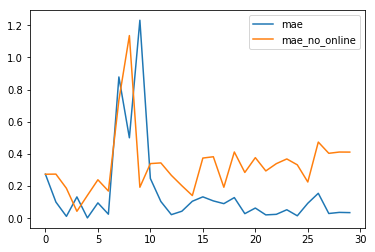

In [7]:
plt.plot(mae, label="mae")
plt.plot(mae_no_online, label="mae_no_online")
plt.legend(loc='best')
plt.show()


In [8]:
np.mean(mae)

0.15917779300787907

In [9]:
np.mean(mae_no_online)

0.33180314077687295

In [25]:
pred_offline=[]
par = PassiveAggressiveRegressor(max_iter=100, random_state=0,tol=1e-3)
start_window = '2018-07-03 00:00:00'
end_window = (datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
window = 15
number_of_windows = 30
list_ = []
timeint = 0
while end_window <= '2018-07-06 12:00:00':
    that_sensor_data = all_static_data[(all_static_data['Timestamp'] > start_window) & (all_static_data['Timestamp'] < end_window) & (all_static_data['lat_grid'] == 4) & (all_static_data['long_grid'] == 6)]
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    that_sensor_data = that_sensor_data.groupby(['lat_grid','long_grid']).mean()
    that_sensor_data.reset_index(level=that_sensor_data.index.names, inplace=True)
    that_sensor_data['Timestamp'] = timeint
    list_.append(that_sensor_data)
    timeint += 1
that_sensor_data = pd.concat(list_, axis = 0, ignore_index = False)
par.fit(that_sensor_data['Timestamp'].values.reshape(-1,1), that_sensor_data['PM2.5'])
print(par.coef_)
print(par.intercept_)
for i in range(number_of_windows):
    pred_offline.append(par.predict([[timeint+i]])[0])

[-0.00301974]
[1.88586017]


In [26]:
pred_offline

[0.8712278090541317,
 0.8682080698746113,
 0.8651883306950909,
 0.8621685915155706,
 0.8591488523360504,
 0.8561291131565301,
 0.8531093739770097,
 0.8500896347974893,
 0.8470698956179692,
 0.8440501564384488,
 0.8410304172589285,
 0.8380106780794081,
 0.8349909388998877,
 0.8319711997203676,
 0.8289514605408472,
 0.8259317213613269,
 0.8229119821818065,
 0.8198922430022864,
 0.816872503822766,
 0.8138527646432456,
 0.8108330254637253,
 0.8078132862842049,
 0.8047935471046848,
 0.8017738079251644,
 0.798754068745644,
 0.7957343295661237,
 0.7927145903866033,
 0.7896948512070832,
 0.7866751120275628,
 0.7836553728480424]

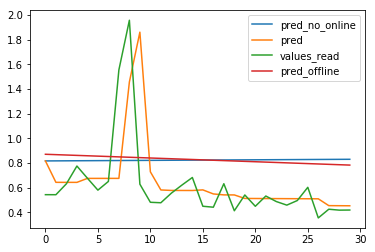

In [27]:
plt.plot(pred_no_online, label="pred_no_online")
plt.plot(pred, label="pred")
plt.plot(values_read, label="values_read")
plt.plot(pred_offline, label="pred_offline")
plt.legend(loc='best')
plt.show()

In [11]:
par_grid[9][5].coef_

array([0.00057427])

In [12]:
par_grid[9][5].intercept_

array([0.7544826])

In [13]:
mean_absolute_error(values_read, pred)

0.15917779300787907

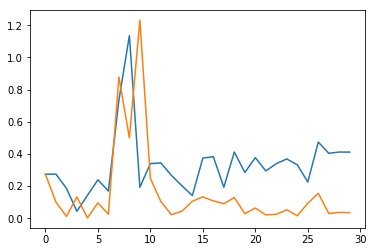

In [14]:
plt.plot(np.abs(np.subtract(values_read, pred_no_online)))
plt.plot(np.abs(np.subtract(values_read, pred)))

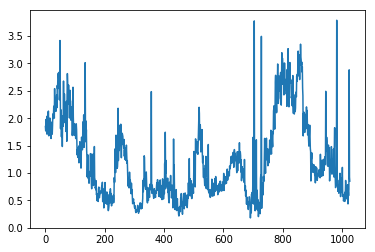

In [34]:
plt.plot(all_static_data[(all_static_data['Timestamp'] > '2018-07-03 00:00:00') & (all_static_data['Timestamp'] < '2018-07-06 14:00:00') & (all_static_data['lat_grid'] == 4) & (all_static_data['long_grid'] == 6)]['PM2.5'].values)